*Nombre de Grupos*: Grupo 1

*Integrantes*:

- Cevasco, Jorge
- Padilla, Ramiro
- Ranieri, Martina

# **Laboratorio 1: Histogram of Oriented Gradients (HOG)**

El descriptor **HOG (Histogram of Oriented Gradients)** es una técnica ampliamente utilizada en visión por computadora para la **detección de objetos**. Captura la estructura o forma de los objetos a través de la distribución de gradientes de intensidad.



## **¿Qué es HOG?**

La idea principal de HOG es que la **apariencia local** y la **forma** de los objetos pueden describirse bien mediante la distribución de **gradientes** (cambios de intensidad) u **orientaciones de borde**.


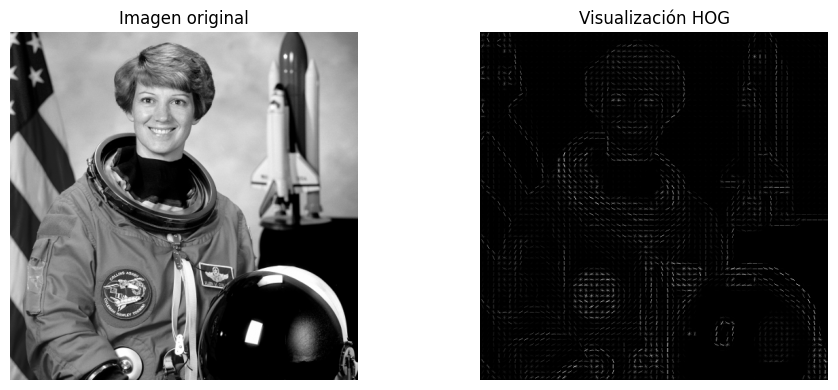

In [ ]:
from skimage import data, color
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Cargar imagen de ejemplo en escala de grises
image = color.rgb2gray(data.astronaut())

# Calcular HOG y su visualización
# Usameremos 9 orientaciones, celdas de 8x8 y bloques de 2x2 celdas para la
# normalizacion L2-Hys.
features, hog_image = hog(image,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(image, cmap='gray')
axs[0].set_title('Imagen original')
axs[0].axis('off')

axs[1].imshow(hog_image, cmap='gray')
axs[1].set_title('Visualización HOG')
axs[1].axis('off')

fig.tight_layout()
plt.show()

In [ ]:
print(f'Vector de características HOG: {features.shape}')
print(features)

Vector de características HOG: (142884,)
[0.34716709 0.13619803 0.         ... 0.12257368 0.18558105 0.06076373]


## ¿Por qué no usar una distribución global?

Una distribución global pierde toda la información espacial. Dos imágenes con estructuras muy distintas pueden tener la misma distribución de bordes global.

## **Pasos generales**:

1. **Preprocesamiento**: Normalización de la imagen (por ejemplo, conversión a escala de grises).
2. **Cálculo de gradientes**: Se usa Sobel o alguna máscara similar.
3. **Celdas**: Dividimos la imagen en pequeñas celdas (por ejemplo, 8x8 píxeles).
4. **Histogramas**: Para cada celda, computamos un histograma de direcciones de gradiente.
5. **Bloques**: Agrupamos celdas en bloques más grandes (por ejemplo, 2x2 celdas), y normalizamos.
6. **Vector final**: Concatenamos todos los histogramas normalizados.


## ***Ejercicio Implementacion: Implementación de HOG***

> Utilizaremos imágenes en escala de grises de tamaño fijo **80x120** píxeles. Para ello, seleccionaremos un recorte o reescalaremos imágenes previamente cargadas.


### **Paso 1: Cargar y preparar la imagen**

> Usaremos la imagen de **Chelsea** (un gato) como ejemplo durante el ejercico. Primero la cargaremos, la pasaremos a escala de grises, y luego la transformaremos a dimensiones **(80, 120)**.



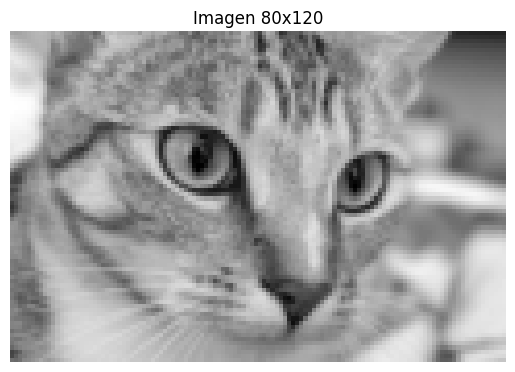

In [ ]:
from skimage import data, color, transform
import matplotlib.pyplot as plt

# Cargar imagen RGB y convertir a escala de grises
image = data.chelsea()  # imagen de un gato
gray = color.rgb2gray(image)

# Reescalar a tamaño fijo (80x120)
resized = transform.resize(gray, (80, 120), anti_aliasing=True)

fig, ax = plt.subplots()
ax.imshow(resized, cmap='gray')
ax.set_title('Imagen 80x120')
ax.axis('off')
plt.show()

### **Paso 2: Calcular los gradientes**

***Ejercicio:*** Implementar el cálculo de gradientes en x e y usando filtros Sobel

> Aplicar los filtros de Sobel para calcular los gradientes en las direcciones horizontal (Gx) y vertical (Gy). Obtener Magnitur y orientacion

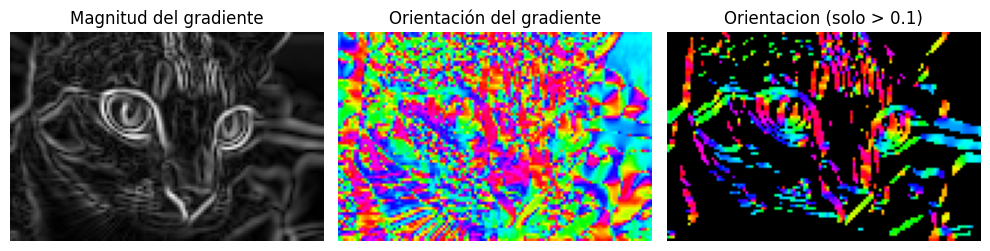

In [ ]:
import numpy as np
from scipy import ndimage
from skimage.filters import sobel_h, sobel_v

# Calcular gradientes
Gx = sobel_v(resized)
Gy = sobel_h(resized)

# Magnitud y ángulo
magnitude = np.hypot(Gx, Gy)
magnitude = np.clip(magnitude, 0, 1)

orientation = np.arctan2(Gy, Gx)

# convertimos los ángulos en [0,180)
orientation = orientation * (180 / np.pi) % 180

# Umbral para magnitud
TREHOLD = 0.1

# Máscara: mantener solo orientaciones con magnitud suficiente
# SOLO PARA FINES VISUALES
orientation_masked = np.where(magnitude > TREHOLD, orientation, np.nan)

hsv_cmap = plt.get_cmap('hsv').copy()
hsv_cmap.set_bad(color='black')

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Mostrar magnitud y orientación
axs[0].imshow(magnitude, cmap='gray')
axs[0].set_title('Magnitud del gradiente')
axs[0].axis('off')

axs[1].imshow(orientation, cmap='hsv')
axs[1].set_title('Orientación del gradiente')
axs[1].axis('off')

axs[2].imshow(orientation_masked, cmap=hsv_cmap)
axs[2].set_title(f'Orientacion (solo > {TREHOLD})')
axs[2].axis('off')

plt.tight_layout()
plt.show()


### **Paso 3: Construir histogramas de orientación**

**Ejercicio:** Dividir la imagen en celdas y calcular histogramas de orientación

> Dividir la imagen en celdas de 8x8 píxeles y calcular un histograma de 9 bins para las orientaciones, realizar la votacion por la magnitud del gradiente.

In [ ]:
# Dado la magnitud y orientacion de cada pixel, el tamaño de las celdas y la cantidad
# de orientaciones, calcula el histograma de orientacion para cada celda.

def computarHistogramaDeCeldas(magnitud, orientacion, cell_size=8, orentacion_bins=9):

  # Podemos suponer que las dimensiones de la imagen sera multiplo de las
  # dimensiones de la celdas.

  # Dividimos la imagen en celdas
  height, width = magnitud.shape
  n_cells_y = height // cell_size
  n_cells_x = width // cell_size

  # Creamos un histograma vacio
  histograms = np.zeros((n_cells_y, n_cells_x, orentacion_bins))

  # Calculamos el ancho de los bind de angulos
  bin_width = 180 // orentacion_bins

  # Calculamos el histograma de cada celda
  for i in range(n_cells_y):
    for j in range(n_cells_x):

      # Calculamos que pixeles formaran parte de la celda
      celda_pixeles_r =(i*cell_size, (i+1)*cell_size)
      celda_pixeles_c =(j*cell_size, (j+1)*cell_size)

      mag_block = magnitud[celda_pixeles_r[0] : celda_pixeles_r[1], celda_pixeles_c[0] : celda_pixeles_c[1]]
      ang_block = orientacion[celda_pixeles_r[0] : celda_pixeles_r[1], celda_pixeles_c[0] : celda_pixeles_c[1]]

      hist = np.zeros(orentacion_bins)

      # COMPLETAR...
        # Por cada pixel de la celda, encontramos su bin correspondiente y
        # agregamos su magnitud al histograma
      for y in range(cell_size):
        for x in range(cell_size):
          mag = mag_block[y,x]
          ang = ang_block[y,x] % 180

          pos_menor = int(np.floor(ang // bin_width))
          ang_menor = ang - (ang % bin_width)


          pos_mayor = (pos_menor + 1) % orentacion_bins

          dif = (ang - ang_menor) / bin_width

          hist[pos_menor] += mag * (1-dif)
          hist[pos_mayor] += mag * dif
          #hist[pos_menor] += mag
          # print(ang)
          # print(ang_menor)
          # print(pos_menor)
          # print(pos_mayor)
          # print(mag)
          # print(hist[pos_menor])
          # print(hist[pos_mayor])
          # print("-----------")


      histograms[i, j] = hist


  return histograms

cell_histograms = computarHistogramaDeCeldas(magnitude, orientation)
print("Forma del array de histogramas por celda:", cell_histograms.shape)

Forma del array de histogramas por celda: (10, 15, 9)


#### Visualizar HOG
> Podemos representar la orientación dominante de cada celda con una línea cuya longitud esté ponderada por la magnitud acumulada en esa dirección.


In [ ]:
from skimage import draw

def visualize_hog_field(cell_histograms, cell_size=8, bins=9, scale=0.4):

  n_cells_row, n_cells_col, _ = cell_histograms.shape

  s_row = n_cells_row * cell_size
  s_col = n_cells_col * cell_size

  hog_image = np.zeros((s_row, s_col), dtype=np.float32)

  # Parámetros de dibujo
  c_row, c_col = cell_size, cell_size
  radius = cell_size // 2 - 1
  orientations_arr = np.arange(bins)
  orientation_bin_midpoints = np.pi * (orientations_arr + 0.5) / 9

  dr_arr = radius * np.sin(orientation_bin_midpoints)
  dc_arr = radius * np.cos(orientation_bin_midpoints)

  # Dibujar líneas por celda y bin
  for r in range(n_cells_row):
    for c in range(n_cells_col):
      for o, dr, dc in zip(orientations_arr, dr_arr, dc_arr):
        center_r = r * c_row + c_row // 2
        center_c = c * c_col + c_col // 2
        rr, cc = draw.line(
            int(center_r - dc),
            int(center_c + dr),
            int(center_r + dc),
            int(center_c - dr)
        )

        # Acumular intensidad del bin en esa celda
        hog_image[rr, cc] += cell_histograms[r, c, o]

  # Normalizar para visualización
  hog_image /= hog_image.max()

  return hog_image


#### Comparacion Con Scikit Image

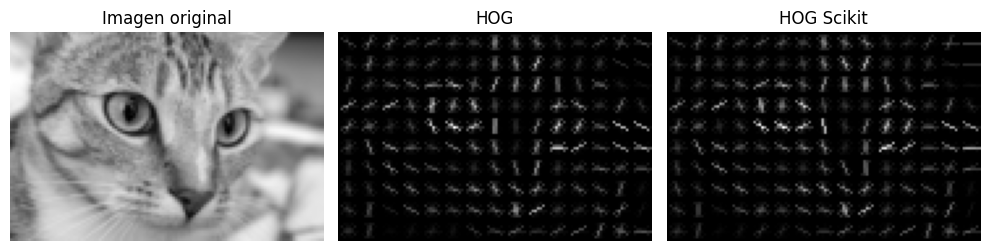

In [ ]:

hogImage = visualize_hog_field(cell_histograms, cell_size=8, bins=9)

_, hogimageScikit = hog(resized,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          block_norm='L2-Hys',
                          visualize=True)

fig, ax = plt.subplots(1,3,figsize=(10, 4))

ax[0].imshow(resized, cmap='gray')
ax[0].set_title('Imagen original')
ax[0].axis('off')

ax[1].set_facecolor('black')
ax[1].imshow(hogImage, cmap='gray')
ax[1].set_title('HOG')
ax[1].axis('off')

ax[2].imshow(hogimageScikit, cmap='gray')
ax[2].set_title('HOG Scikit')
ax[2].axis('off')

fig.tight_layout()
plt.show()



### **Paso 4: Normalización por bloques**

**Ejercicio**: Normalizar los histogramas por bloques 2x2 celdas

> Aplicar normalización L2 sobre bloques de 2x2 celdas contiguas para obtener invariancia a iluminación y contraste.

In [ ]:
def normalizarBloques(cell_histograms, block_size=2):

  n_cells_y, n_cells_x, bins = cell_histograms.shape

  n_blocks_y = n_cells_y - block_size + 1
  n_blocks_x = n_cells_x - block_size + 1

  features = []

  # Por cada uno de los bloques, encontramos sus celdas y normalizamos
  for i in range(n_blocks_y):
    for j in range(n_blocks_x):
      # Encontramos su celda y las concatenamos
      block = cell_histograms[i:i+block_size, j:j+block_size].ravel()
      # COMPLETAR...rest
        # Calcular la norma del vector con los histogramas del bloque
      norma = np.linalg.norm(block)
      if norma==0:
        norma = 1
        # Normalizar el vector por esta norma
      block /= norma
        # Lo agregamos al vector de features de la imagen
      features.append(block)

  return np.concatenate(features)

hog_features = normalizarBloques(cell_histograms)

print("Tamaño del vector HOG final:", hog_features.shape)

Tamaño del vector HOG final: (4536,)




---



## **Detector de Peatones con HOG + SVM**

Con HOG ya implementado, ahora lo utilizaran para crear un detector de peatones en imagenes. Para esto necesitaran entrenar una SVM con los descriptores de HOG para poder clasificar secciones de una imagen entre si contienen un peaton o no lo hacen. Como dataset de entrenamiento utilizaran `INRIA Person Dataset` ya subido en el campus.

La implementacion estara fuertemente basada en el siguiente paper: [**Histograms of Oriented Gradients for Human Detection**](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

### **SVM**

Un SVM (Support Vector Machine) es un clasificador supervisado que encuentra el mejor hiperplano que separa dos clases, es decir, el que obtenga la mayor distancia (margen) entre los puntos de categorias diferentes mas cercanos.

El hiperplano deberia cumplir:

- $x$ es de clase $ 1⇒ w^Tx+b ≥ 1$

- $x$ es de clase $ 0⇒ w^Tx+b ≤ 0$

donde $w$ es el vector normal al hiperplano y b su offset.

Para predecir en nuevas entradas haremos:

- $w^Tx+b > 0 ⇒ $ $x$ es de clase 1

- $w^Tx+b < 0 ⇒ $ $x$ es de clase 0

Aunque no este en el scope de la materia, pueden encontrar mas informacion sobre svm en: [Support Vector Machines, Main Ideas](https://www.youtube.com/watch?v=efR1C6CvhmE) y [Understanding the mathematics behind Support Vector Machines](https://shuzhanfan.github.io/2018/05/understanding-mathematics-behind-support-vector-machines/)

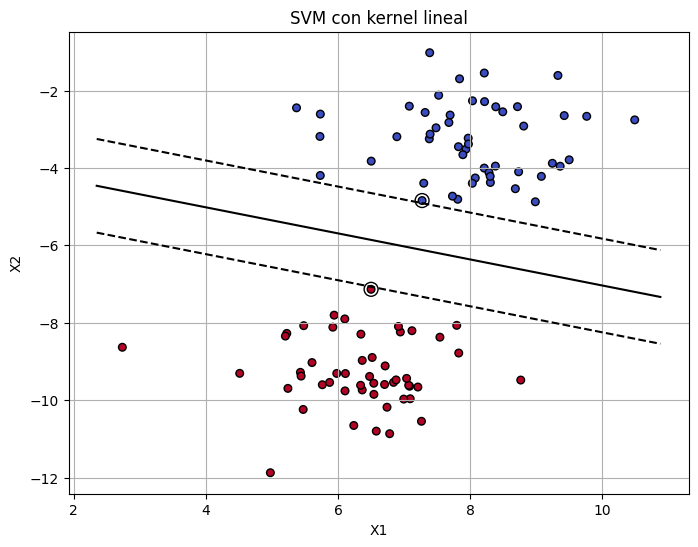

In [ ]:
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

# Generamos datos sintéticos: dos clases separables
X, y = make_blobs(n_samples=100, centers=2, random_state=6)

# Creamos un clasificador SVM lineal
# El kernel es la forma en la que transformaremos los datos de entrada
# para hacer posible el separarlos con un hiperplano.
# Por ser el computacionalmente mas barato, en este trabajo usaremos el kernel lineal.
clf = SVC(kernel='linear')

# Entrenamos el categorizador, X siendo los datos de entrada y Y el vector con
# la categorias correspondientes (0, 1)
clf.fit(X, y)

# Visualizamos los datos
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', s=30, edgecolors='k')

# Dibujamos la línea de decisión, el hiperplano
# si el producto punto entre el vector de entrada y el hiperplano es mayora a 1,
# entonces sera categoria 1. Si el producto en menor a -1, sera categoria 0.
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Crear malla para graficar la recta de decisión
xx = np.linspace(xlim[0], xlim[1], 30)
w = clf.coef_[0] # Vector normal
b = clf.intercept_[0] # offset
yy = -(w[0] * xx + b) / w[1]

# Dibujar márgenes
margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
yy_plus = yy + margin
yy_minus = yy - margin

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_plus, 'k--')
plt.plot(xx, yy_minus, 'k--')

# Dibujar los vectores de soporte
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=100, linewidth=1, facecolors='none', edgecolors='k')

plt.title("SVM con kernel lineal")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()

In [ ]:
new_point = np.array([[3, 5]])

# Hacer predicción
pred = clf.predict(new_point)[0]
print(f"El modelo predice la clase: {pred}")

El modelo predice la clase: 0




---



### ***Ejercicio***: Recolectar los descriptores de HOG y utilizarlos para entrenar una SVM

In [ ]:
import os
import numpy as nprest
from skimage import io, color
from skimage.feature import hog

def read_filenames(pos_img_dir, neg_img_dir):
    """
    Lee los nombres de archivos de las carpetas de imágenes positivas y negativas.
    """
    f_pos = sorted([f for f in os.listdir(pos_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    f_neg = sorted([f for f in os.listdir(neg_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return f_pos, f_neg

In [ ]:
def crop_centre(img, target_size=(120, 80)):
    h, w = img.shape[:2]
    th, tw = target_size
    start_y = (h - th) // 2
    start_x = (w - tw) // 2
    return img[start_y:start_y + th, start_x:start_x + tw]

def ten_random_windows(image, window_size=(120, 80), num_windows=10):
    h, w = image.shape
    win_h, win_w = window_size
    windows = []

    for _ in range(num_windows):
        y = np.random.randint(0, h - win_h)
        x = np.random.randint(0, w - win_w)
        window = image[y:y + win_h, x:x + win_w]
        windows.append(window)

    return windows

Funciones auxiliares implementadas por nosotros:

In [ ]:
from sklearn.utils import shuffle
from sklearn import svm
import joblib

def obtener_mag_y_orientacion(img):
  # Calcular gradientes
  Gx = sobel_v(img)
  Gy = sobel_h(img)

  # Magnitud y ángulo
  magnitude = np.hypot(Gx, Gy)
  magnitude = np.clip(magnitude, 0, 1)

  orientation = np.arctan2(Gy, Gx)

  # convertimos los ángulos en [0,180)
  orientation = orientation * (180 / np.pi) % 180

  return magnitude, orientation

def aplicar_hog(img):
  mag, ori = obtener_mag_y_orientacion(img)
  cell_hists = computarHistogramaDeCeldas(mag, ori)
  vector_hog = normalizarBloques(cell_hists)
  return vector_hog

In [ ]:
def read_images(pos_files, neg_files, pos_img_dir, neg_img_dir):
    """
    Lee imágenes positivas y negativas, extrae características HOG y asigna etiquetas.
    """
    X = [] # Vector de datos de entrada
    Y = [] # Vector de clases correspondientes

    pos_count = 0
    neg_count = 0

    # Proceso imágenes positivas
    for img_file in pos_files:
        path = os.path.join(pos_img_dir, img_file)
        print(f"Leyendo positivo: {path}")
        img = io.imread(path)

        gray = color.rgb2gray(crop_centre(img))

       # COMPLETAR...
        hog = aplicar_hog(gray)

        X.append(hog)
        Y.append(1)
       #  Recolectar Hog y agregar su Label Correspondiente en X, Y
        pos_count += 1

    # Proceso imágenes negativas (varias ventanas por imagen)
    for img_file in neg_files:
        path = os.path.join(neg_img_dir, img_file)
        print(f"Leyendo negativo: {path}")
        img = io.imread(path)
        gray = color.rgb2gray(img)

        windows = ten_random_windows(gray)  # Esta debe devolver una lista de regiones 80x120

        for win in windows:
            # COMPLETAR...
            #  Recolectar Hog y agregar su Label Correspondiente en X, Y
            hog = aplicar_hog(win)
            X.append(hog)
            Y.append(0)

            neg_count += 1

    return np.array(X), np.array(Y), pos_count, neg_count

### Entrenamiento

In [ ]:
# Leemos los archivos de test
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pos_img_dir = 'ruta/a/positivos'
pos_img_dir = '/content/drive/MyDrive/ElemReconVisual/TP1/pos'
#neg_img_dir = 'ruta/a/negativos'
neg_img_dir = '/content/drive/MyDrive/ElemReconVisual/TP1/neg'

# Leer archivos
pos_img_files, neg_img_files = read_filenames(pos_img_dir, neg_img_dir)
print(f"Total Positive Images: {len(pos_img_files)}")
print(f"Total Negative Images: {len(neg_img_files)}")
print("Leyendo imágenes...")

# Leer y procesar imágenes
X, Y, pos_count, neg_count = read_images(pos_img_files, neg_img_files, pos_img_dir, neg_img_dir)

# Convertir a arrays numpy y mezclar
X = np.array(X)
Y = np.array(Y)
X, Y = shuffle(X, Y, random_state=0)

print("Imágenes leídas y mezcladas")
print(f"Positivos: {pos_count}")
print(f"Negativos: {neg_count}")
print("Entrenando clasificador ...")

# Entrenamiento con LinearSVC
clf1 = svm.LinearSVC(C=0.01, max_iter=1000, class_weight='balanced', verbose=1)
clf1.fit(X, Y)

print("Clasificador entrenado. Guardando...")
joblib.dump(clf1, 'person_preliminary.pkl') # RECUERDEN ENTREGAR ESTO

Total Positive Images: 2420
Total Negative Images: 1218
Leyendo imágenes...
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001a.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001b.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001c.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001d.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001e.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001001f.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001002a.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001002b.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001002c.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001002d.png
Leyendo positivo: /content/drive/MyDrive/ElemReconVisual/TP1/pos/crop001003a.png
Leyendo positivo: /content/drive/

['person_preliminary.pkl']

### ***Ejercicio Final***: Utilizar el SVM entrenado para detectar peatones en una imagen y analizar los resultados:

**Procedimiento**: Recorran la imagenees en ventanas de 80x120 y verifiquen si contiene o no un peaton utilizando su predictor, dibujen un rectangulo sobre las secciones que si contengan uno.

Luego responda las siguientes **preguntas**, muestren ejemplos y justifiquen mostrando el propio funcionamiento de su detector si es necesario:

- ¿Qué tan bien funciona su detector?

 - ¿Detecta correctamente la mayoría de los peatones en diferentes imágenes?

 - ¿Cuáles son los principales errores que observan: falsos positivos o falsos negativos?

 - ¿En qué tipo de imágenes (simples vs complejas) se comporta mejor?

- ¿Qué podrían mejorar y cómo lo harían?

  - ¿Ajustarían algún parámetro de HOG? ¿Del clasificador SVM?

  - ¿Agregarían más datos de entrenamiento? ¿Qué tipo de datos?

  - ¿Implementarían técnicas de preprocesamiento o postprocesamiento adicionales?

- ¿Por qué creen que HOG funciona para detección de personas?

    - ¿Qué aspectos de una persona típica (cuerpo, contorno, forma) captura bien el descriptor HOG?

    - ¿Cómo influyen las orientaciones y los bordes en la robustez de la descripción?

- ¿En qué tipo de imágenes creen que el detector tiene peor rendimiento?

  - ¿Escenarios con mucha textura o ruido?

  - ¿Sombras, iluminaciones extremas o fondos confusos?

  - ¿Personas en poses no verticales o parcialmente visibles?

- ¿Cómo podrían hacerlo más robusto a cambios de escala?

  - ¿Qué estrategias implementaron para detectar personas más pequeñas o grandes?

  - ¿Qué otras alternativas conocen o podrían investigar (por ejemplo, pirámides de imagen o multiscale HOG)?

- ¿Qué otros tipos de variaciones podrían afectar el desempeño?

  - ¿Cambios de iluminación, oclusiones, rotaciones leves?

  - ¿Cómo podrían minimizar esos efectos?

- Comparación crítica

  - Si conocen redes neuronales (CNN), ¿cómo creen que este enfoque tradicional se compara con un detector moderno basado en aprendizaje profundo?

In [ ]:
import matplotlib.pyplot as plt
from skimage import io, color
import matplotlib.patches as patches
import joblib

window_size = (120, 80)  # Dimensiones de la ventana
step_size = 20           # De a cuanto desplazo la ventana

def detectar_peatones(imagen, modelo):
    detecciones = []

    # Convertir imagen a escala de grises si es RGB, caso contrario no hago nada
    if imagen.ndim == 3:
        imagen = color.rgb2gray(imagen)

    n, m = imagen.shape
    win_n, win_m = window_size

    for y in range(0, n - win_n + 1, step_size):
        for x in range(0, m - win_m + 1, step_size):
            ventana = imagen[y:y + win_n, x:x + win_m]

            hog = aplicar_hog(ventana)
            hog = hog.reshape(1, -1)

            pred = modelo.predict(hog)

            if pred == 1:  # Se detectó un peatón
                detecciones.append((x, y, win_n, win_m))

    return detecciones

In [ ]:
def mostrar_detecciones(imagen, detecciones):
    fig, ax = plt.subplots(1)
    ax.imshow(imagen, cmap='gray')

    for (x, y, n, m) in detecciones:
        rect = patches.Rectangle((x, y), m, n, linewidth=2, edgecolor='r', facecolor='none') # Funcion implementada en plt para marcar con rectangulos
        ax.add_patch(rect)

    plt.title("Detecciones de peatones")
    plt.show()

In [ ]:
# Cargamos el modelo ya entrenado
clf1 = joblib.load('person_preliminary.pkl')

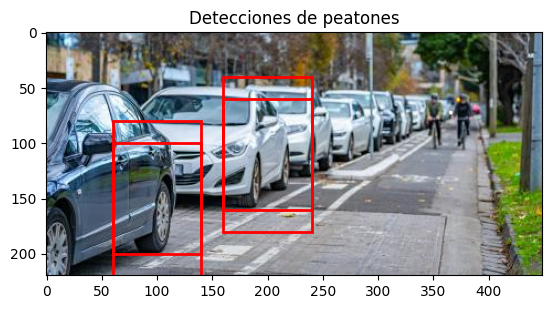

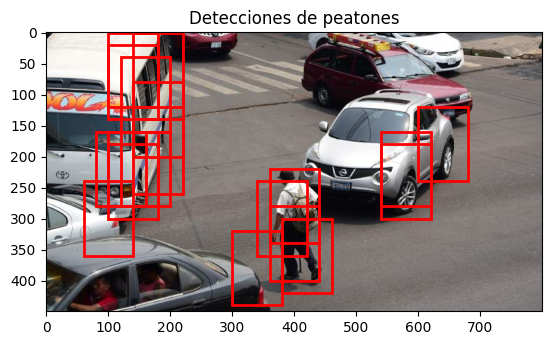

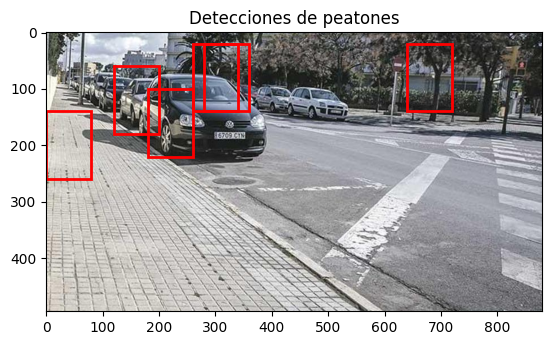

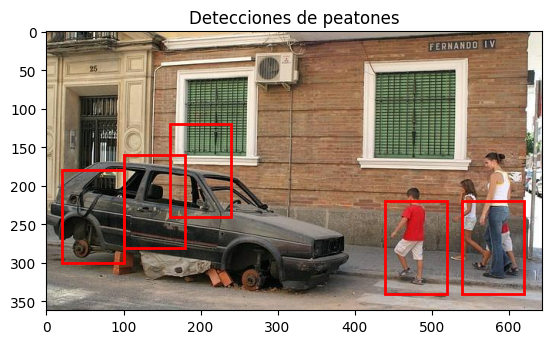

In [ ]:
# Muestro todas las detecciones en las imagenes bajo la carpeta "pruebas"

folder_path = "/content/pruebas"

pos_files, _ = read_filenames(folder_path, folder_path)


for img_file in pos_files:
  path = os.path.join(folder_path, img_file)
  #print(f"Leyendo positivo: {path}")
  img = io.imread(path)
  detecciones = detectar_peatones(img, clf1)
  mostrar_detecciones(img, detecciones)